
# California Housing — Neural Network Regression (Keras)


In [4]:
!pip install -U tensorflow scikit-learn matplotlib numpy pandas

In [5]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


## 1. Load & Inspect the California Housing data

In [6]:
cal = fetch_california_housing(as_frame=True)
X = cal.data
y = cal.target 
print(X.shape, y.shape)
X.head()


(20640, 8) (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 2. Train/Validation/Test split and scaling

In [7]:

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

X_train_sc[:3]


array([[ 0.44340968, -0.12449485,  0.5204714 ,  0.05758629, -0.48710064,
         0.05165771,  1.10281811, -0.69155432],
       [ 0.00321001, -1.07770852, -0.17083875, -0.04872181,  1.69902706,
        -0.05515937, -0.72493883,  0.8544348 ],
       [-0.52181236, -0.20392932, -0.06125032,  0.28089603, -0.13535041,
        -0.01697183, -0.88428174,  0.86440892]])

## 3. Baseline model: Linear Regression

In [8]:

linreg = LinearRegression(n_jobs=None) if hasattr(LinearRegression, 'n_jobs') else LinearRegression()
linreg.fit(X_train_sc, y_train)
y_val_pred_lr = linreg.predict(X_val_sc)
y_test_pred_lr = linreg.predict(X_test_sc)

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

baseline_val = metrics(y_val, y_val_pred_lr)
baseline_test = metrics(y_test, y_test_pred_lr)
print("Baseline (Linear Regression) — Validation:", baseline_val)
print("Baseline (Linear Regression) — Test:", baseline_test)


Baseline (Linear Regression) — Validation: {'MSE': 0.5386059660291247, 'RMSE': 0.7338977899061454, 'MAE': 0.5407140746076861, 'R2': 0.6097023914123486}
Baseline (Linear Regression) — Test: {'MSE': 0.5544725485137045, 'RMSE': 0.7446291348810524, 'MAE': 0.5334738187856252, 'R2': 0.5768706123655902}


## 4. Keras model factory

In [10]:

def build_mlp(
    input_dim: int,
    hidden_layers=(64, 32),
    activation="relu",
    optimizer="adam",
    l2_reg=0.0,
    dropout=0.0,
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation,
                               kernel_regularizer=keras.regularizers.l2(l2_reg) if l2_reg>0 else None))
        if dropout>0:
            model.add(layers.Dropout(dropout))
    # Linear output for regression: predicts any real value
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=optimizer,
        loss="mse", 
        metrics=["mae"]
    )
    return model


## 5. Training utility 

In [11]:

def train_and_eval(name, **kwargs):
    model = build_mlp(input_dim=X_train_sc.shape[1], **kwargs)
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    ]
    start = time.time()
    history = model.fit(
        X_train_sc, y_train,
        validation_data=(X_val_sc, y_val),
        epochs=200,
        batch_size=64,
        verbose=0,
        callbacks=callbacks
    )
    duration = time.time() - start

    # Metrics
    y_train_pred = model.predict(X_train_sc, verbose=0).ravel()
    y_val_pred = model.predict(X_val_sc, verbose=0).ravel()
    y_test_pred = model.predict(X_test_sc, verbose=0).ravel()

    res = {
        "name": name,
        "train": metrics(y_train, y_train_pred),
        "val": metrics(y_val, y_val_pred),
        "test": metrics(y_test, y_test_pred),
        "epochs": len(history.history["loss"]),
        "seconds": duration,
        "history": history.history,
    }
    return model, res


## 6. Experiments

In [13]:

results = []

# 6.1 Activation: relu vs tanh
_, res_relu = train_and_eval("relu-64x32-adam",
                             hidden_layers=(64,32), activation="relu", optimizer="adam")
results.append(res_relu)

_, res_tanh = train_and_eval("tanh-64x32-adam",
                             hidden_layers=(64,32), activation="tanh", optimizer="adam")
results.append(res_tanh)

# 6.2 Depth: shallow vs deep (ReLU)
_, res_shallow = train_and_eval("relu-32-adam",
                                hidden_layers=(32,), activation="relu", optimizer="adam")
results.append(res_shallow)

_, res_deep = train_and_eval("relu-128x64x32-adam",
                             hidden_layers=(128,64,32), activation="relu", optimizer="adam")
results.append(res_deep)

# 6.3 Optimizer: adam vs sgd (same arch)
_, res_adam = train_and_eval("relu-64x32-adam",
                             hidden_layers=(64,32), activation="relu", optimizer="adam")
results.append(res_adam)

_, res_sgd = train_and_eval("relu-64x32-sgd",
                            hidden_layers=(64,32), activation="relu", optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9))
results.append(res_sgd)

len(results)


6

## 7. Results summary

In [14]:

def flat_row(r):
    return {
        "name": r["name"],
        "val_MSE": r["val"]["MSE"],
        "val_RMSE": r["val"]["RMSE"],
        "val_MAE": r["val"]["MAE"],
        "test_MSE": r["test"]["MSE"],
        "test_RMSE": r["test"]["RMSE"],
        "test_MAE": r["test"]["MAE"],
        "epochs": r["epochs"],
        "seconds": r["seconds"],
    }

df_res = pd.DataFrame([flat_row(r) for r in results]).sort_values("val_RMSE")
display(df_res)


,name,val_MSE,val_RMSE,val_MAE,test_MSE,test_RMSE,test_MAE,epochs,seconds
3,relu-128x64x32-adam,0.267820,0.517513,0.353708,0.271138,0.520709,0.351260,64,138.572830
5,relu-64x32-sgd,0.276489,0.525822,0.351718,0.272291,0.521815,0.347416,59,105.477273
1,tanh-64x32-adam,0.277614,0.526891,0.362197,0.271550,0.521105,0.355947,124,246.202733
4,relu-64x32-adam,0.285278,0.534115,0.365169,0.285332,0.534165,0.365345,59,177.447908
0,relu-64x32-adam,0.285783,0.534586,0.363283,0.280824,0.529928,0.360504,54,104.600400
2,relu-32-adam,0.323950,0.569166,0.397151,0.326034,0.570994,0.390236,79,152.321114


## 8. Training curves

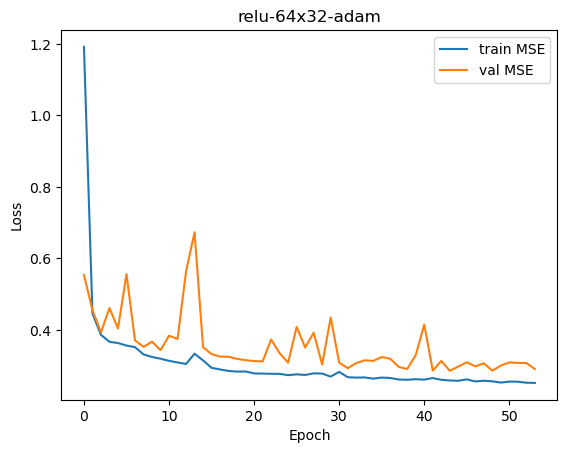

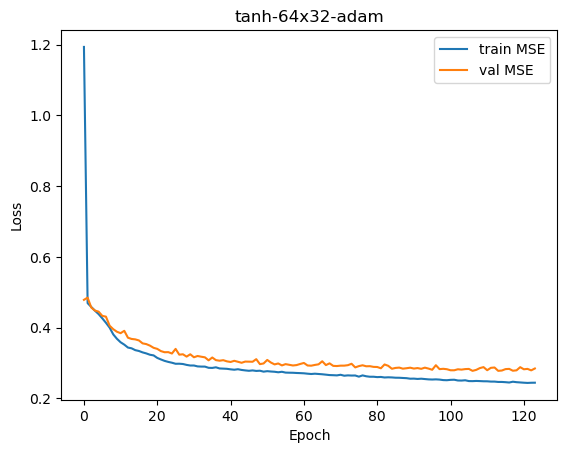

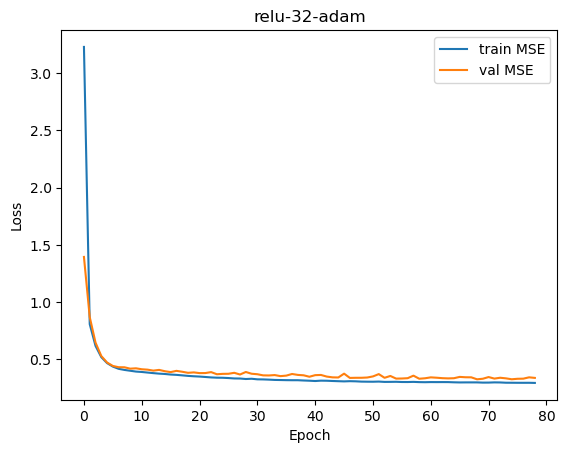

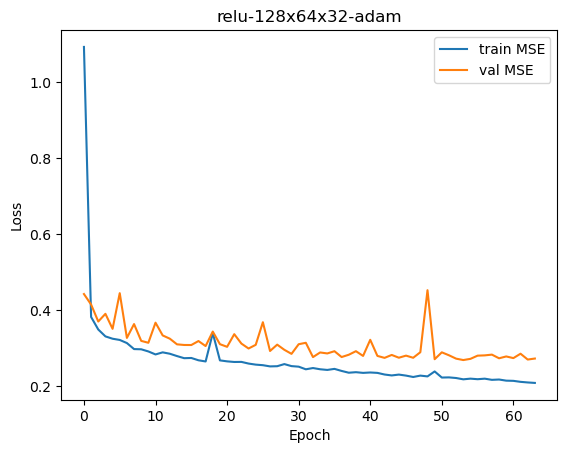

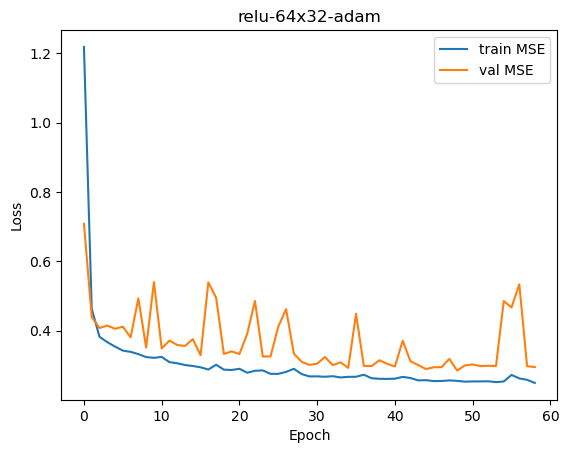

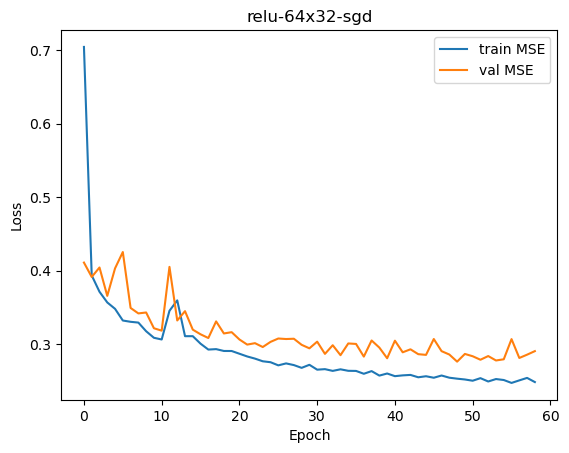

In [15]:

def plot_history(r):
    h = r["history"]
    plt.figure()
    plt.plot(h["loss"], label="train MSE")
    plt.plot(h["val_loss"], label="val MSE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(r["name"])
    plt.legend()
    plt.show()

for r in results:
    plot_history(r)



## 9. Discussion — Key Questions

### Q1) ReLU vs tanh in hidden layers
- **ReLU** usually trains faster and avoids vanishing gradients for positive activations.
- **tanh** is zero-centered and can help when inputs are standardized; it may be smoother but can still saturate.
- Empirically, check which gives **lower validation RMSE** for this dataset.

### Q2) Why linear output (not sigmoid)?
- Regression targets are **unbounded real values** (house prices in $100k units).  
- A **linear** activation allows the output neuron to represent any real number.  
- A **sigmoid** compresses outputs to (0,1), which would **squash** predictions and harm learning unless you perform special scaling; even then, linear is the standard for regression.

### Q3) Do deeper models always help?
- Not always. Depth increases capacity but also the risk of **overfitting** and **longer training**.  
- Compare shallow vs deep results; if validation RMSE worsens while training RMSE improves, that's a sign of overfit.

### Q4) MSE vs MAE vs RMSE
- **MSE**: squares errors → penalizes large errors **more** (sensitive to outliers). Used as loss for smoother gradients.
- **RMSE**: sqrt(MSE) → back to target units, easier to interpret ("average error in target units").
- **MAE**: linear penalty → more **robust to outliers**, median-friendly interpretation.


## 10. Evaluate the best model on the hold-out test set

In [16]:

best = min(results, key=lambda r: r["val"]["RMSE"])
print("Best by val RMSE:", best["name"])
print("Test metrics:", best["test"])


Best by val RMSE: relu-128x64x32-adam
Test metrics: {'MSE': 0.2711381463700156, 'RMSE': 0.5207092724064126, 'MAE': 0.3512597106938445, 'R2': 0.7930889127957648}
